<a href="https://colab.research.google.com/github/massirism/ML-UNS/blob/main/TP7_Massiris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
ds = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBHP/data/housing_data.csv")
ds.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560262,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [85]:
#Librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from math import sqrt
sns.set_style('darkgrid')

In [86]:
#Lo hago para checkear que no tengo valores nulos en la data
ds.isnull().sum()
#print(ds)

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [87]:
#Para sacar los datos nulos
df=ds.dropna()
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [88]:
#Bien, ahora que el dataset está limpio separaré el target de las demás variables.
#La 13 es MEDV que es el valor medio del valor de cada casa. Por eso lo llevo entre -1 a 1
x = df.iloc[:, 0:13].values
y = df.iloc[:, 13].values.reshape(-1,1)


In [89]:
print(x)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [4.5270e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 9.0800e+00]
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]]


In [ ]:
#print(y)

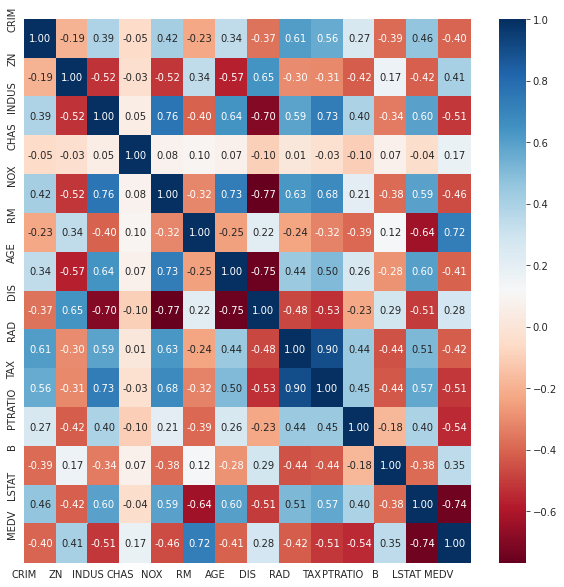

In [91]:
#Para terminar esta etapa quisera ver comon se relacionan las variables entre sí, entonces presento el mapa de calor
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

A continuación aplicaré 2 métodos para reducir la dimensionalidad de la data, se puede ver en el mapa de calor que hay variables que pueden eliminarse. El primer método es "Feature Elimination manual" y el segundo es "Feature Importance With Random Forrest Regression". 

In [92]:
abs(df.corr()["MEDV"]) 

CRIM       0.397230
ZN         0.406822
INDUS      0.510829
CHAS       0.173701
NOX        0.459054
RM         0.723951
AGE        0.407470
DIS        0.279547
RAD        0.416638
TAX        0.508864
PTRATIO    0.543809
B          0.347256
LSTAT      0.743450
MEDV       1.000000
Name: MEDV, dtype: float64

# Método 1: Feature selection MANUAL.

In [93]:
#abs(df.corr()["MEDV"][abs(df.corr()["MEDV"])>0.5].drop('MEDV')).index.tolist()

['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']

In [94]:
vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))
cv = KFold(n_splits=10, random_state=None, shuffle=False) #Cross validation

#Con este for varía el "umbral" de la covarianza con respécto al target MEDV, por eso para el primer caso están la mayoría de las variables
for val in vals:
    features = abs(df.corr()["MEDV"][abs(df.corr()["MEDV"])>val].drop('MEDV')).index.tolist()
    
    X = df.drop(columns='MEDV')
    X=X[features]
    
    print(features)

    y_pred = cross_val_predict(classifier_pipeline, X, y, cv=cv)
    print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
    print("R_squared: " + str(round(r2_score(y,y_pred),2)))

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
RMSE: 5.25
R_squared: 0.67
['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
RMSE: 5.12
R_squared: 0.69
['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
RMSE: 5.3
R_squared: 0.66
['ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
RMSE: 5.25
R_squared: 0.67
['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
RMSE: 4.74
R_squared: 0.73
['RM', 'LSTAT']
RMSE: 4.54
R_squared: 0.75
['RM', 'LSTAT']
RMSE: 4.54
R_squared: 0.75


# Método 2: Feature selection.

In [95]:
df=ds.dropna()
df.isnull().sum()
#Preparo nuevamente el data
X = df.iloc[:, 0:13].values
y = df.iloc[:, 13].values.reshape(-1,1)


## Feature Importance With Random Forrest Regression
La idea es usar un bosque de árboles para evaluar la importancia de las características en una tarea de clasificación.

In [96]:
#Ahora separaré la data de entrenamiento y testeo, 70/30 respectivamente
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (275, 13)
Shape of X_test:  (119, 13)
Shape of y_train:  (275, 1)
Shape of y_test (119, 1)


In [97]:

#Ahora preparo el modelo para el entrenamiento
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=99)
forest.fit(X_train, y_train) 
importances = forest.feature_importances_
print(importances) #Calc


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


[0.05004622 0.00103763 0.0071775  0.00227787 0.02485829 0.42260485
 0.01102769 0.04454143 0.00376225 0.02066917 0.02213024 0.01248733
 0.37737955]


Elapsed time to compute the importances: 0.012 seconds


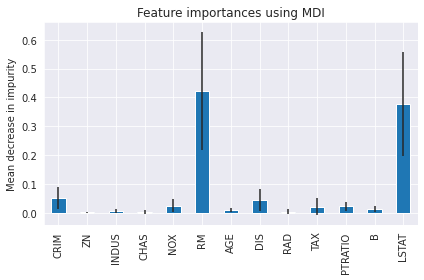

In [98]:
#Gráfica de las variables más importantes
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

import pandas as pd
features=abs(df.corr()["MEDV"][abs(df.corr()["MEDV"])>0.].drop('MEDV')).index.tolist()

#print(features)
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [99]:
print('R2 for Train)', forest.score( X_train, y_train ))
print('R2 for Test (cross validation)', forest.score(X_test, y_test))

R2 for Train) 0.9793432068800018
R2 for Test (cross validation) 0.8923173593779065


In [100]:
#Ahora preparo el modelo para el entrenamiento y busco las variables más importantes
X = df.iloc[:,0:13]

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(forest, prefit=True, max_features=3)
feature_idx = model.get_support()
feature_names = X.columns[feature_idx]
X_NEW = model.transform(X)
pd.DataFrame(X_NEW, columns= feature_names)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,RM,LSTAT
0,6.575,4.98
1,6.421,9.14
2,7.185,4.03
3,6.998,2.94
4,6.430,5.21
...,...,...
389,5.569,15.10
390,6.027,14.33
391,6.120,9.08
392,6.976,5.64


In [101]:
#Ahora luego de filtrar las variables y quedarme con 2: 'RM' y 'LSTAT', REspliteo la data de entrenamiento y validación.

X_train, X_test, y_train, y_test = train_test_split(X_NEW, y, test_size=0.3, random_state=0)
lm = LinearRegression()
lm.fit( X_train, y_train )
print('R2 for Train)', lm.score( X_train, y_train ))
print('R2 for Test (cross validation)', lm.score(X_test, y_test))


R2 for Train) 0.6761835173351991
R2 for Test (cross validation) 0.6053341278097532


# Conclusión: 
En las dos soluciones planteadas se llegó a la misma conclusión, las dos variables que más importan son: 'RM' y 'LSTAT' y el resto pueden ser descartadas porque se logran valores de R2 aceptables prescindiendo de ellas.

En primera instancia pareciera que el primer método logró mejores resultados con un R2 de 0.75 pero este resultado debería ser menor, ya que para este método no ví necesario separar los datos en entrenamiento y validación ya que ese sería el objetivo del segundo método. El verdadero objetivo del primer método es validar las variables elegidas por el segundo método.


Al final el modelo con solo 2 variables obtuvo resultados aceptables, despreciando las otras variables.